# Satellite Derived Bathymetry - Stumpf Method

This example uses stumpf method to derive bathymetry as mentioned in this article https://doi.org/10.4319/lo.2003.48.1_part_2.0547

## Imports

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import cmocean
import sys

sys.path.append(r'C:\Users\sergi\Documents\repos\geopy\geopy')

import reader
import plot
from bathymetry.models import stumpf_pseudomodel, LinearModel
from bathymetry.metrics import ValidationSummary
from bathymetry.plot import CalibrationPlot, ValidationPlot
from masks import is_valid, is_in_range
from preprocessing.outliers import IQR
from enums import SENTINEL2_BANDS

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Load Satellite Image

In [3]:
satellite = reader.open(r"D:\marine_observatory\raw\Sentinel-2\31SED\S2A_MSI_2018_09_05_10_50_03_T31SED_L2W.nc")
satellite.rename_by_enum(SENTINEL2_BANDS)
satellite.rename({'Rrs_B2' : 'Blue', 'Rrs_B3' : 'Green', 'Rrs_B4' : 'Red'})
satellite.drop_bands( set(satellite.band_names).difference(['Blue', 'Green', 'Red']) )

Bands: ['Blue', 'Green', 'Red'] | Height: 10980 | Width: 10980

In [4]:
balears = gpd.read_file(r"D:\repos\geopy_usage\areas\baleares\baleares.shp").to_crs(satellite.crs).geometry

satellite.clip(balears)

Bands: ['Blue', 'Green', 'Red'] | Height: 1096 | Width: 913

## Pseudomodel Green

(<GeoAxes: >, <cartopy.mpl.gridliner.Gridliner at 0x20abca7ced0>)

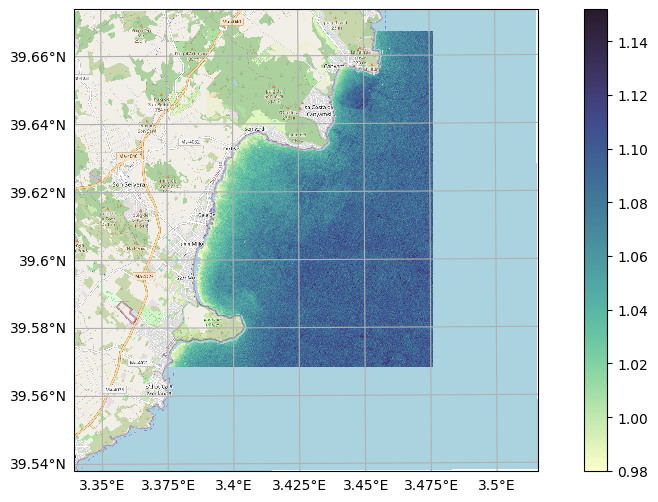

In [5]:
P_SDB_GREEN = 'pSDB Green'

satellite.add_band(P_SDB_GREEN, IQR( stumpf_pseudomodel(satellite.select('Blue'), satellite.select('Green')), distance = 3 ))

fig, ax = plot.get_geofigure(satellite.crs, 1, 1)
plot.add_basemap(ax, 3.372645, 39.565, 3.4717, 39.665, satellite.crs)
ax, mappable = plot.plot_band(satellite, P_SDB_GREEN, ax = ax, cmap = cmocean.cm.deep)
fig.colorbar(mappable, )
plot.add_gridlines(ax)

## Load In-Situ Depths

(<GeoAxes: >, <cartopy.mpl.gridliner.Gridliner at 0x20abcb73290>)

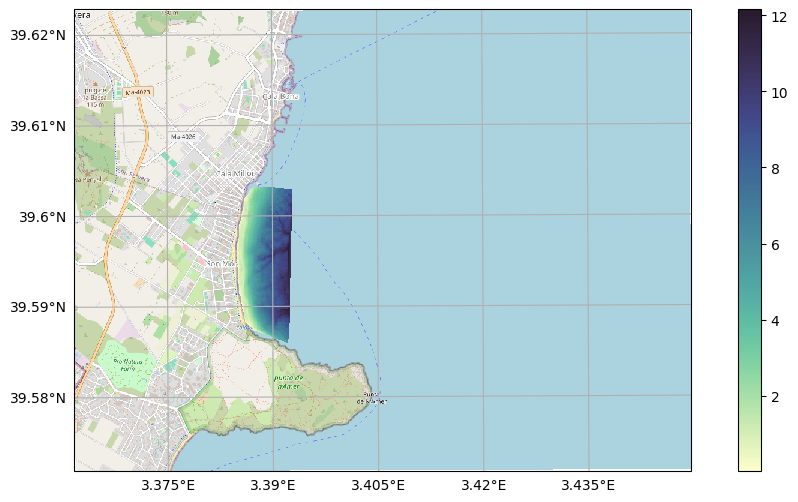

In [6]:
DEPTH = 'Depth'

in_situ = reader.open(r"D:\CallaMillor.tif")
in_situ.rename({'Band 1' : DEPTH})
in_situ.mask(in_situ.select(DEPTH) < 0) ## Positive values are land so they are masked
in_situ.add_band(DEPTH, abs(in_situ.select(DEPTH)) ) ## For model calibration we need depths as positive values
in_situ.dropna()

fig, ax = plot.get_geofigure(in_situ.crs, 1, 1)
plot.add_basemap(ax, 3.372645, 39.579722, 3.436343, 39.60927, in_situ.crs)
ax, mappable = plot.plot_band(in_situ, DEPTH, ax = ax, cmap = cmocean.cm.deep)
fig.colorbar(mappable)
plot.add_gridlines(ax)

## Align In-Situ with Satellite dimensions

In [7]:
in_situ.align(satellite)
in_situ.dropna()
satellite.clip([in_situ.bbox])

Bands: ['Blue', 'Green', 'Red', 'pSDB Green'] | Height: 191 | Width: 67

## In-situ and Pseudomodel

(<GeoAxes: title={'center': 'In-Situ Depth'}>,
 <cartopy.mpl.gridliner.Gridliner at 0x20abfe62890>)

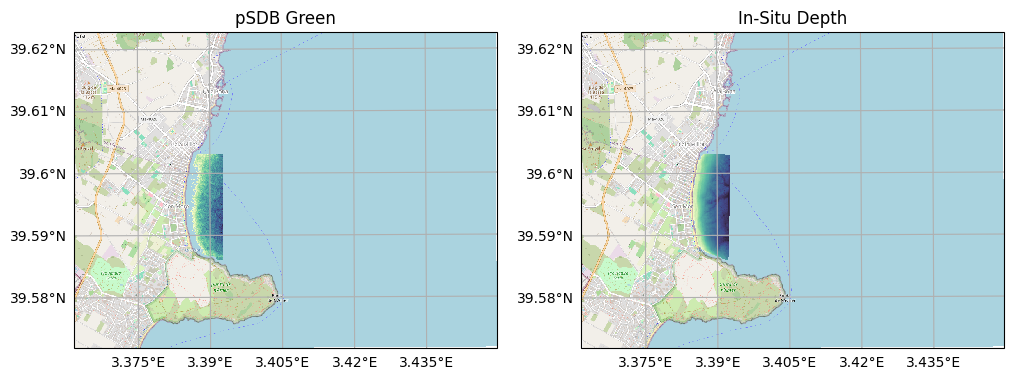

In [8]:
fig, axs = plot.get_geofigure(satellite.crs, 1, 2)
plot.add_basemap(axs[0], 3.372645, 39.579722, 3.436343, 39.60927, satellite.crs)
plot.plot_band(satellite, P_SDB_GREEN, axs[0], cmap = cmocean.cm.deep)
plot.add_basemap(axs[1], 3.372645, 39.579722, 3.436343, 39.60927, in_situ.crs)
_, mappable = plot.plot_band(in_situ, DEPTH, ax = axs[1], cmap = cmocean.cm.deep)

axs[0].set_title('pSDB Green')
axs[1].set_title('In-Situ Depth')
plot.add_gridlines(axs[0])
plot.add_gridlines(axs[1])

## Calibration

### Select random depths

**arginterval_choice** returns a list of indexes. the band is transformed to 1D internaly, so we **must** transform our bands to 1D when masking.

In [9]:
selection = in_situ.arginterval_choice(band = DEPTH, size = 3, intervals = range(5, 10))

### Extract depths and pseudomodel as 1D-arrays

In [10]:
depths = in_situ.select(DEPTH).ravel()
p_green = satellite.select(P_SDB_GREEN).ravel()

### Fit model

In [11]:
to_cal_depths = depths[selection]
to_cal_p_greens = p_green[selection]
no_nans = is_valid(to_cal_depths) & is_valid(to_cal_p_greens)

calibration = LinearModel().fit(to_cal_p_greens[no_nans], to_cal_depths[no_nans])

print(f'N: {len(to_cal_depths[no_nans])}, Calibration: {calibration}')

N: 12, Calibration: R: 0.6140 | y = 74.411x-68.248


### Plot model

<Axes: title={'center': 'pSDB Green vs Depth'}, xlabel='pSDB Green', ylabel='Depth'>

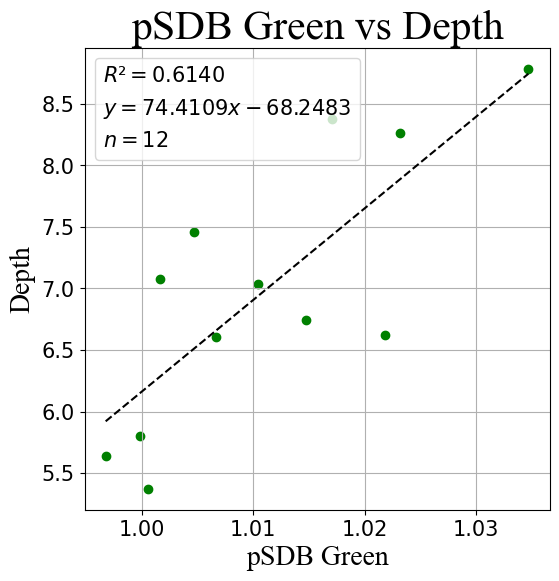

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
cal_plot = CalibrationPlot(legend_font_size = 15)
cal_plot.add_calibration_scatter(calibration, to_cal_p_greens[no_nans], to_cal_depths[no_nans], ax = ax)
cal_plot.add_labels(ax, title = f'{P_SDB_GREEN} vs {DEPTH}', xlabel = P_SDB_GREEN, ylabel = DEPTH)
cal_plot.add_legend(ax)

## SDB Generation

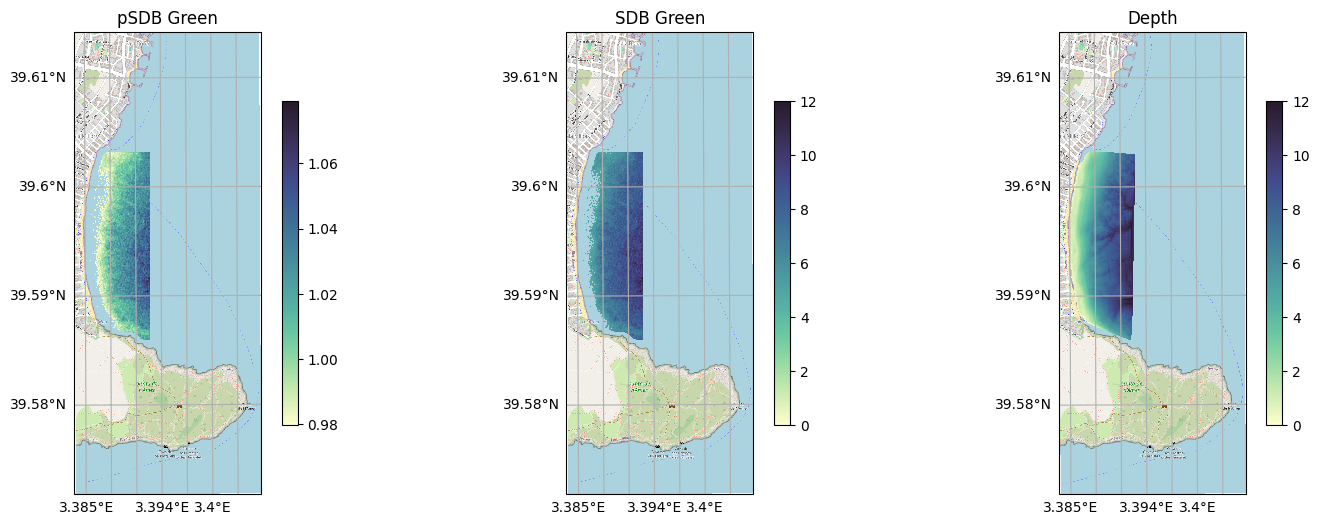

In [13]:
SDB_GREEN = 'SDB Green'

satellite.add_band(SDB_GREEN, calibration.predict(satellite.select(P_SDB_GREEN)))


fig, axs = plot.get_geofigure(satellite.crs, 1, 3, figsize = (18, 6))
for image, band, crs, title, vmin, vmax, ax in zip([satellite, satellite, in_situ], [P_SDB_GREEN, SDB_GREEN, DEPTH],
                                                   [satellite.crs, satellite.crs, in_situ.crs], [P_SDB_GREEN, SDB_GREEN, DEPTH],
                                                   [None, 0, 0], [None, 12, 12], axs):
    plot.add_basemap(ax, 3.39, 39.58, 3.4, 39.61, crs)
    ax, mappable = plot.plot_band(image, band, ax, cmap = cmocean.cm.deep, vmin = vmin, vmax = vmax)
    fig.colorbar(mappable, shrink = 0.7)
    plot.add_gridlines(ax)
    ax.set_title(title)

## Validation

### Indexes of values to compare

In [14]:
validation_indexes = ~np.isin(np.arange(in_situ.select(DEPTH).size), selection)
validation_indexes

array([ True,  True,  True, ...,  True,  True,  True], shape=(12797,))

### Metrics

In [15]:
depths = in_situ.select(DEPTH).ravel()[validation_indexes]
green = satellite.select(SDB_GREEN).ravel()[validation_indexes]

no_nans = is_valid(depths) & is_valid(green)

validation = ValidationSummary(in_situ = depths[no_nans], model = green[no_nans])
validation

N: 8797 | MSD: 0.0715 | MedAE: 0.7025 | Abs_std: 0.67275

### Plot

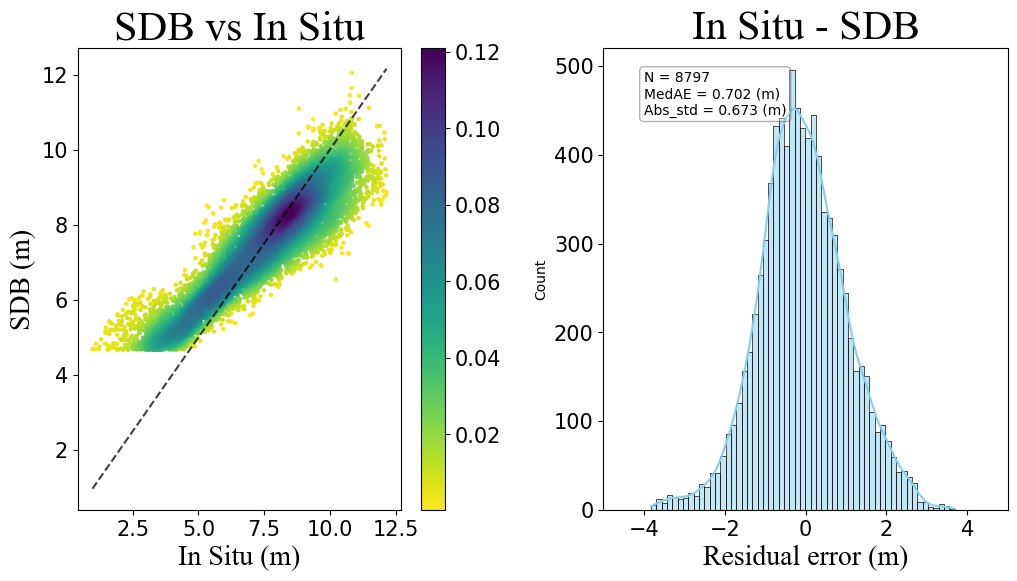

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

val_plot = ValidationPlot(legend_font_size = 10)
val_plot.add_densed_scatter(validation, axs[0])
val_plot.add_residuals(validation, axs[1], metrics = ['MedAE', 'Abs_std'])
plt.subplots_adjust(wspace = 0.3)

## Bathymetry

Text(0.5, 1.0, 'In-Situ')

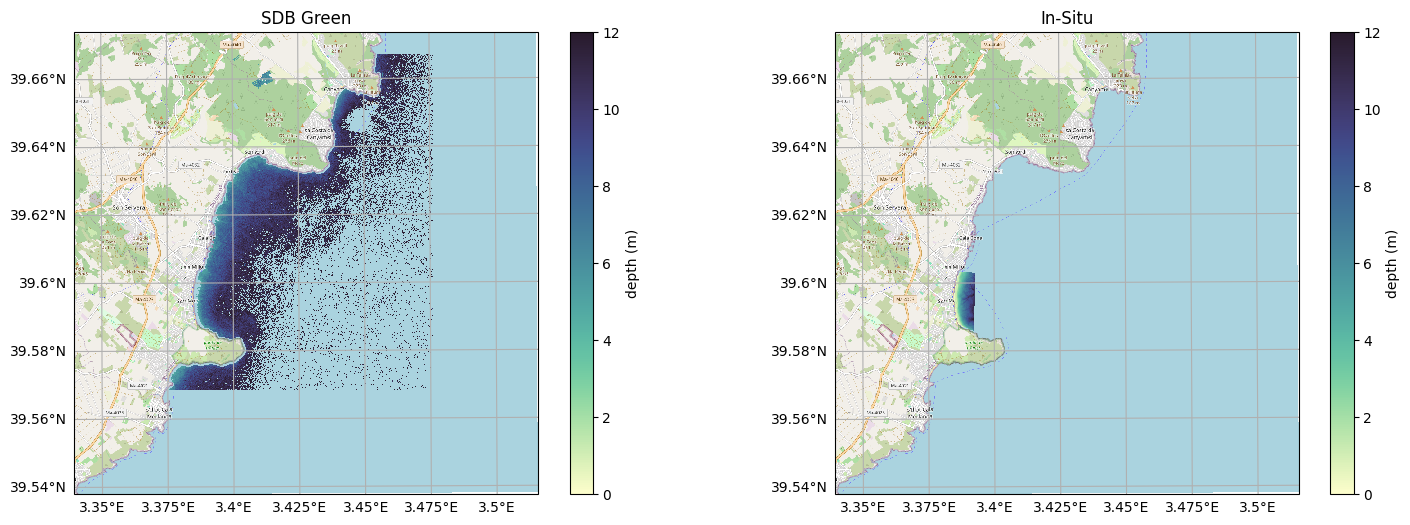

In [ ]:
satellite = reader.open(r"D:\marine_observatory\raw\Sentinel-2\31SED\S2A_MSI_2018_09_05_10_50_03_T31SED_L2W.nc")
satellite.rename_by_enum(SENTINEL2_BANDS)
satellite.rename({'Rrs_B2' : 'Blue', 'Rrs_B3' : 'Green', 'Rrs_B4' : 'Red'})
satellite.drop_bands( set(satellite.band_names).difference(['Blue', 'Green', 'Red']) )
satellite.clip(balears)

satellite.add_band(P_SDB_GREEN, IQR( stumpf_pseudomodel(satellite.select('Blue'), satellite.select('Green')), distance = 3 ))

satellite.add_band(SDB_GREEN, calibration.predict(satellite.select(P_SDB_GREEN)))
satellite.mask(satellite.select(SDB_GREEN) < 12) ## Satellite doens't see more than 12m in this study area so we keep values up-to 12m.


fig, axs = plot.get_geofigure(satellite.crs, 1, 2, figsize = (18, 6))

plot.add_basemap(axs[0], 3.372645, 39.565, 3.4717, 39.665, satellite.crs)
axs[0], mappable = plot.plot_band(satellite, SDB_GREEN, axs[0], cmap = cmocean.cm.deep, vmin = 0, vmax = 12)
fig.colorbar(mappable, label = 'depth (m)')
plot.add_gridlines(axs[0])
axs[0].set_title(SDB_GREEN)

plot.add_basemap(axs[1], 3.372645, 39.565, 3.4717, 39.665, in_situ.crs)
axs[1], mappable = plot.plot_band(in_situ, DEPTH, axs[1], cmap = cmocean.cm.deep, vmin = 0, vmax = 12)
fig.colorbar(mappable, label = 'depth (m)')
plot.add_gridlines(axs[1])
axs[1].set_title('In-Situ')